In [10]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath(".."))
from src.model import CNNmodel
import torch
from src.dataloaders import create_data_loaders

Setting up model for visualisations using validation data

In [16]:
y_true = []
y_pred = []

labels = pd.read_csv(
        "E:/Coding_stuffs/Python/notebooks/Medical_image_classification/data/raw/histopathologic-cancer-detection/train_labels.csv"
    )
labels["file_path"] = (
    "E:/Coding_stuffs/Python/notebooks/Medical_image_classification/data/processed/medical_images_resized/"
    + labels["id"]
    + ".png"
    )
train_loader, val_loader = create_data_loaders(labels, batch_size=128)

model = CNNmodel()
model.load_state_dict(
        torch.load(
            "E:/Coding_stuffs/Python/notebooks/Medical_image_classification/models/model.pth"
        )
    )
model.to("cuda")
model.eval()

CNNmodel(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (fc2): Linear(in_features=256, ou

The model was able to achieve an AUC of 0.986 on the validation data, descriminates well between cancerous and non cancerous histopathology images.

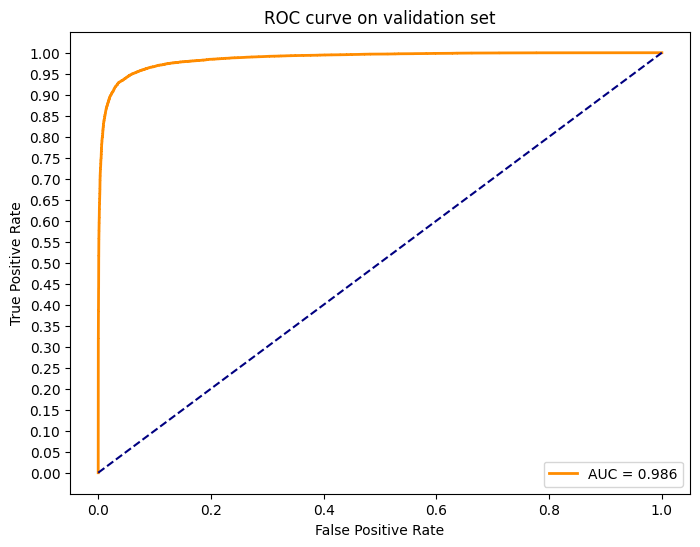

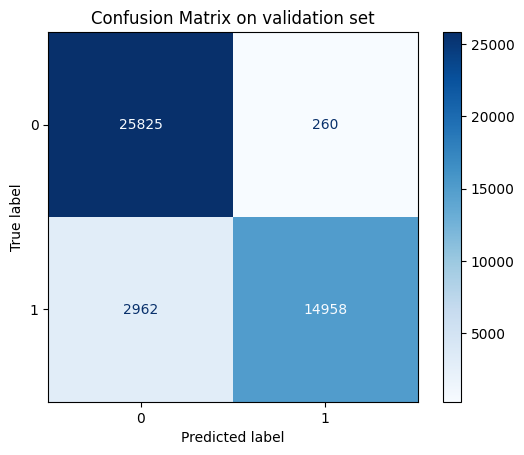

Classification Report on validation set:
              precision    recall  f1-score   support

         0.0     0.8971    0.9900    0.9413     26085
         1.0     0.9829    0.8347    0.9028     17920

    accuracy                         0.9268     44005
   macro avg     0.9400    0.9124    0.9220     44005
weighted avg     0.9320    0.9268    0.9256     44005



In [17]:

#ROC Curve
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to("cuda"), labels.to("cuda")
        outputs = model(images)
        probs = torch.sigmoid(outputs).squeeze().cpu().flatten()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(probs)

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.yticks(np.arange(0, 1.05, 0.05))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve on validation set")
plt.legend(loc="lower right")
plt.show()

#Confusion Matrix
y_pred = (np.array(y_pred) >= 0.85).astype(int)
c_mat = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=c_mat)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix on validation set")
plt.show()

#Classification Report
print("Classification Report on validation set:")
print(classification_report(y_true, y_pred, digits=4))